In [3]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 4.4.1 정규 방정식<sub>normal equation</sub>

(단, *invertible* 할때 = 각 subspace 들이 독립일 때)

#### 테스트 데이터 생성

In [4]:
X = 2* np.random.rand(100, 1) # 100 row, 1 col
y = 4 + 3*X  + np.random.randn(100,1) # 100 row, 1col

In [12]:
print('X :' , X[:5] )

X : [[0.74908024]
 [1.90142861]
 [1.46398788]
 [1.19731697]
 [0.31203728]]


In [13]:
print('y :' , y[:5] )

y : [[6.33428778]
 [9.40527849]
 [8.48372443]
 [5.60438199]
 [4.71643995]]


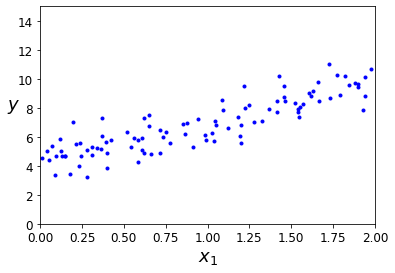

In [17]:
plt.plot(X,y, "b.")
plt.xlabel("$x_1$", fontsize = 18)
plt.ylabel("$y$", rotation = 0, fontsize=18)
plt.axis([0,2, 0, 15])
plt.show()

In [24]:
X_b = np.c_[np.ones((100,1)), X] # X0 = 1 을 추가 해준다
theta_best = np.dot(np.dot(np.linalg.inv(np.dot(X_b.T, X_b)), X_b.T), y)

In [25]:
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

In [26]:
theta_best

array([[4.21509616],
       [2.77011339]])

$\theta_0 = 4.215$ , $\theta_1 = 2.770$  
원래의 방적식은 $y = 4 + 3x_1$ 
>잡음이 섞인 결과가 도출 됨

In [28]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = np.dot(X_new_b, theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

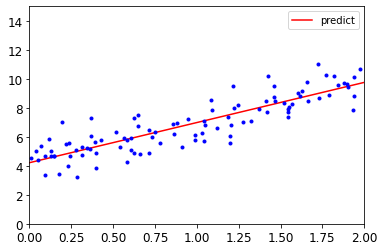

In [31]:
plt.plot(X_new, y_predict, "r-", label = "predict")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.legend()
plt.show()

#### 사이킷런

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg= LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [35]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`LinearRegression`은 `scipy.linalg.lstsq()` 함수 **최소 제곱<sub>least squares</sub>**을 기반으로 함

In [37]:
theta_best_svd, residuals, rank,s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

위 함수는 $\hat{\theta} = X^+ y$를 계산한다. 여기서 $X^+$는 X의 **유사역행렬**<sub>pseudoinverse</sub>를 가르킨다.  
`np.linalge.pinv()`를 사용해서 유사역행렬을 직접 구할 수 있다.

In [40]:
np.linalg.pinv((X_b)).dot(y)

array([[4.21509616],
       [2.77011339]])

$ X^+ $(유사 역행렬)은 SVD에서 구해지는 값.   
정규 방정식<sub>normal equation</sub>에서 $Col A$의 Subspace에서 종속(dependent) 한 관계가 존재 할 때, 값을 구 할 수 없었는데 SVD는 역행렬이 존재 하지 않아도 유사 역행렬은 항상 구할 수 있다.

### 4.1.2 Computational Complexity
정규 방정식<sub>normal equation</sub>에서는 $ (n+1) * (n+1) $ 횟수 만큼의 연산($ X^{T} X $)을 수행한다. ($n$은 Column, 특성 수).   
이러한 역행렬을 계산하는 계산복잡도<sub>Computational Complexity</sub> 은 일 반적으로 $ O(n^{2.4})$ ~$ O(n^{3}) $  
Sklearn의 `LinearRegression` 클래스가 사용하는 SVD 방식은 $O(n^2)$이다

## 4.2 경사 하강법
경사 하강법<sub>gradient descent</sub>의 기본 아이디어는 *Cost Function*을 최소화 하기 위해 반복적으로 파라미터를 조정해 가는 것  
*parameter* 벡터 $ \theta $ 에 대해 *Cost Function*의 현재 Gradient를 계산 하여, Gradient가 감소되는 방향으로 전진힌다. Gradient가 0에 도달 하면 최솟값에 도달 한 것  
** 무작위 초기화 ** <sub>random initialization</sub>: $\theta$의 값을 임의의 값으로 시작해서 한 번에 조금씨 Cost Function(ex. MSE)이 감쇠되는 방향으로 진행하여 최소값을 찾는다

경사 하강법에서 중요한 하이퍼파라미터는 **학습률**(learning rate, $\eta$)이다. 학습률이 너무 작으면 수렴하는데까지 시간이 오래걸리고, 학습률이 너무 크면 발산하게 된다. 보통 로그 스케일로 0.001($10^{-3}$), 0.001($10^{-2}$)와 같이 지정한다.

>경사 하강법을 사용할 때는 반드시 모든 특성(feature)들이 같은 스케일을 가지도록 해야한다(Standard 또는 MinMax 등). 그렇지 않으면 학습시간이 오래걸리게 된다.   


![](./images/gd.gif)

이를 모델의 **파라미터 공간**<sub>parameter space</sub>에서 파라미터 조합을 찾는다 라고 한다

### 4.2.1 경사 하강법

$$
\frac{\partial}{\partial w_j} MSE(\mathbf{W}) = \frac{2}{m} \sum_{i=1}^{m}{\left( \mathbf{W}^{T} \cdot \mathbf{x}_{i} - y_{i}\right)}x_{ij}
$$

위 편도함수를 계한 하는 대신 **그라디언트 벡터** $\nabla_{\mathbf{W}} \text{MSE}(\mathbf{\theta}) $를 계산한다. $\nabla_{\mathbf{W}} \text{MSE}(\mathbf{\theta}) $는 각 비용 함수의 *Col A*의 특성(subsapce) 마다 편도함수를 모두 담고 있다. 

$$
\nabla_{\mathbf{W}} \text{MSE}(\mathbf{W}) = \begin{bmatrix} \frac { \partial  }{ \partial w_{ i } } { MSE }(W) \\ \vdots \\ \frac { \partial  }{ \partial w_{ i } } { MSE }(W) \end{bmatrix} = \frac{2}{m} \mathbf{X}^{T} \cdot \left( \mathbf{X} \cdot \mathbf{W} - \mathbf{y} \right)
$$

#### 경사 하강법 Step

$$
\mathrm{W} \leftarrow \mathrm{W} - \eta \nabla_{\mathbf{W}} \text{MSE}(\mathbf{W}) \Longleftrightarrow 
 \mathrm{W} \leftarrow \mathrm{W} - \eta \frac{\partial L}{\partial \mathrm{W}} 
$$

In [71]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100 # 특성 수

theta = np.random.randn(2,1)  # 가중치 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [72]:
W

array([[4.21509616],
       [2.77011339]])

#### 여러 학습룰에 따른 경사 하강법

In [73]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

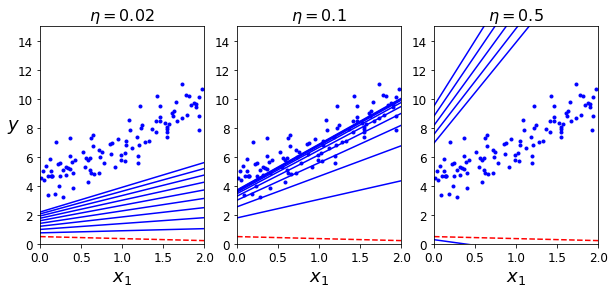

In [74]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

- 학습률이 너무 작다(왼쪽): Optimal에 도달하는데 오랜 시간 소요(최적화 무의미)
- 학습률이 적당하다: 최적에 수럼
- 학습률이 너무 크다(오른쪽): 발산 해버린다.

#### iteration 횟수 설정 방법
반복 횟수를 아주 크게 설정하고, Gradient Vector가 아주 작아지면(기울기가 아주 작아지면), 즉 벡터의 Norm이 어떤 값 $\varepsilon $(허용오차<sub> tolerance</sub>)보다 작아지면 경사하강법이 거의 최솟값에 도달한 것이므로 알고리즘 중지한다.

### 4.2.2 확률적 경사 하강법 <sub> Stochastic Gradient Descent</sub>  
배치 경사 하강법의 단점은 각 스텝(iter)에서 모든 훈련 세트를 사용 -> 매우 느리다.   


**확률적 경사 하강법**(Stochastic Gradient Descent)은 매 스텝(iter)에서 랜덤하게 하나의 데이터(샘플)을 선택해 Gradient Descent를 계산한다.  
따라서, 전체 데이터를 이용해 GD를 계산하는 것보다 속도는 빠르지만 훨씬 불안정하다.   
비용 함수(Loss Function)가 최소값에 수렴할 때까지 부드럽게 감소하지 않고, 위아래로 요동치면서 평균적으로 감소한다.  
  
SGD는 비용함수가 매우 불규칙 할때, 알고리즘이 Local Minium을 건너 뛰도록 도와주므로, SGD가 BGD보다 Local Minium에 빠지 확률이 적고 Global Minium에 도달할 가능성이 높다.  

하지만,  Global Minium $\neq$ Global Optimal이다. 즉, Global Minium을 잘 탈출 시켜 주지만, BGD보다 Global Optimal을 찾을 가능성이 낮다. 이를 해결 하기 위해서 학습률을 점진적으로 감소 시키는 **learning rate decay** 기법을 사용한다. 

learning rate decay(또는 learning rate schedule)는 학습을 시작할 때는 학습률을 크게하고, 점진적으로 학습률을 줄여 전역 최소값에 도달하게 하는 방법이다.


In [75]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

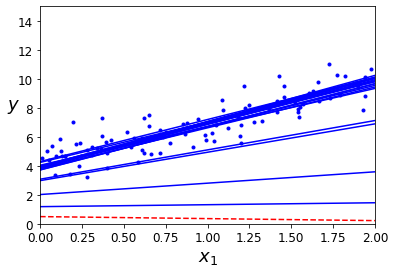

In [76]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                   
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()                                           

In [77]:
theta

array([[4.21076011],
       [2.74856079]])

sklearn에서 SGD 방식으로 선형회귀를 사용하기 위해서는 기본값으로 MSE 함수를 최적화 하는 `SGDRegressor`를 사용한다.

In [78]:
from sklearn.linear_model import SGDRegressor
# 최대 1000번의 epoch, 허용오차: 0.001, 학습률: 0.1
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [79]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 4.2.3 미니배치 경사 하강법<sub>Mini-batch gradient descent</sub>

**미니배치 경사 하강법**(Mini-batch Gradient Descent)은 각 스텝에서 전체 Train Set을  미니배치(mini-batch), 즉 작은 데이터셋을 추출한 뒤 Gradient를 계산하는 방법이다. 미니배치 경사하강법의 장점은 행렬 연산에 최적화된 하드웨어, GPU에서 빠르게 수행되는 것이다. 

미니배치 경사 하강법은 SGD에 비해 덜 불규칙하게 감소하지만, local minimum에 빠질 확률은 높은 경우가 있다.

In [80]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [81]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

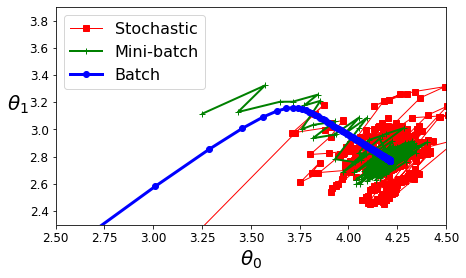

In [82]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

모두 최소값 긑처에 도달했지만, BGD가 Global Optimal에 멈춘 반면,  
SGD와 미니배치 경사 하강법은 근처에서 맴돌고 있다. -> learning schedule 필요

#### 배치 경사 하강법 (Batch Gradient Descent: BGD)
배치 경사 하강법이란, 전체 학습 데이터를 하나의 배치로(배치 크기가 n) 묶어 학습시키는 경사 하강법  
(**배치**: **GPU가 한번에 처리하는 데이터의 묶음**)

전체 데이터에 대한 모델의 오차의 평균을 구한 다음, 이를 이용하여 미분을 통해 경사를 산출, 최적화를 진행한다.
보통 딥러닝 라이브러리에서 배치를 지정하지 않으면 이 방법을 쓰고 있다고 생각할 수 있다.

배치 경사 하강법의 특징은 아래와 같다.

- 전체 데이터를 통해 학습시키기 때문에, 가장 업데이트 횟수가 적다. (1 Epoch 당 1회 업데이트)
- 전체 데이터를 모두 한 번에 처리하기 때문에, 메모리가 가장 많이 필요하다.
- 항상 같은 데이터 (전체 데이터)에 대해 경사를 구하기 때문에, 수렴이 안정적이다.   

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fxzcf3%2FbtqEuYhYtuF%2FjfMqBQlOKTq94H15yADKrK%2Fimg.png" width="500" width="auto" align="center">


#### 확률적 경사 하강법 (Stochastic Gradient Descent: SGD)
확률적 경사 하강법은 전체 데이터 중 **단 하나의 데이터를 이용하여 경사 하강법을 1회 진행**(배치 크기가 1)하는 방법이다.
전체 학습 데이터 중 랜덤하게 선택된 하나의 데이터로 학습을 하기 때문에 확률적 이라 부른다.

배치 경사 하강법에 비해 적은 데이터로 학습할 수 있고, 속도가 빠른 장점이 있다. 무엇보다 큰 특징은 **수렴에 Shooting이 발생한다는 점이다.**

각 데이터에 대한 손실값의 기울기는 약간씩 다르기 때문에, 손실값의 평균이 아닌 개별 데이터에 대해 미분을 수행하면 기울기의 방향이 매번 크게 바뀐다.  
 
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F7hWCJ%2FbtqEuYhZtI9%2FYXwknUwaKcMhJOdhTUyRR1%2Fimg.png" width="500" width="auto" align="center">        
  

그러나 결국 학습 데이터 전체에 대해 보편적으로 좋은 값을 내는 방향으로 수렴한다. 다만, 최저점에 안착하기는 어렵다.

또한, Shooting은 최적화가 지역 최저점Local Minima에 빠질 확률을 줄여준다.

- 한 번에 하나의 데이터를 이용하므로 GPU의 병렬 처리를 그다지 잘 활용하지는 못한다.
- 1회 학습할 때 계산량이 줄어든다.
- Global Minimum에 수렴하기 어렵다.
- 노이즈가 심하다. (Shooting이 너무 심하다.)



#### 미니 배치 확률적 경사 하강법 (Mini-Batch Stochastic Gradient Descent: MSGD)
딥러닝 라이브러리 등에서 SGD를 얘기하면 최근에는 대부분 이 방법을 의미한다.
SGD와 BGD의 절충안으로, 전체 데이터를 `batch_size`개씩 나눠 배치로 학습(배치 크기를 사용자가 지정)시키는 것이다.

예를 들어, 전체 데이터가 1000개인 데이터를 학습시킬 때, batch_size가 100이라면, 전체를 100개씩 총 10 묶음의 배치로 나누어 1 Epoch당 10번 경사하강법을 진행한다.

Shooting이 발생하기는 하지만, 한 배치의 손실값의 평균으로 경사하강을 진행하기 때문에, Shooting이 심하지는 않다.  

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbkVbjU%2FbtqEtOUJD9H%2FL9KHdOnSukjHnhlRwRERy1%2Fimg.png" width="500" width="auto" align="center">  


- BGD보다 계산량이 적다. (Batch Size에 따라 계산량 조절 가능)
- Shooting이 적당히 발생한다. (Local Minimum를 어느정도 회피할 수 있다.)


배치는 경사 하강법 1회에 사용되는 데이터의 묶음이다.  
배치의 크기에 따라 아래와 같이 나눌 수 있다.  
- (배치 크기) == (전체 학습 데이터): 배치 경사 하강법 (BGD)
- (배치 크기) == 1: 확률적 경사 하강법 (SGD)
- (배치 크기) == (사용자가 지정) 미니 배치 확률적 경사 하강법 (MSGD)  

In [67]:
theta_path_sgd

array([], dtype=float64)